<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
from torch import nn
import scipy.io as io
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from torch.optim import SGD, Adam
from torch.utils import data
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
train_snr = 15
M = 4 **2
NN_T = 64
NN_R=512

In [3]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(M, NN_T)  # 6*6 from image dimension
        self.fc2 = nn.Linear(NN_T, NN_T)
        self.fc3 = nn.Linear(NN_T, 8)
        
    def forward(self, in_message):
        x = F.relu(self.fc1(in_message))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        transmitted = x / torch.sqrt(2*torch.mean(x**2))
        return transmitted
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(4+4, NN_R)
        self.fc2 = nn.Linear(NN_R, NN_R)
        self.fc3 = nn.Linear(NN_R, NN_R)
        self.fc4 = nn.Linear(NN_R, M)
    def forward(self, in_message, in_channel):
        nn_input = torch.cat([in_message,in_channel],-1)
        x = F.relu(self.fc1(nn_input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        decoded = F.log_softmax(self.fc4(x), dim=-1)
        return decoded
        

In [4]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

criterion= nn.NLLLoss()
opt = Adam(list(encoder.parameters())+list(decoder.parameters()), lr=0.001)


Path = 'AE_open_loop_4QAM_model'

checkpoint = torch.load(Path)
encoder.load_state_dict(checkpoint['Encoder'])
decoder.load_state_dict(checkpoint['Decoder'])

<All keys matched successfully>

In [5]:
##### Uncomment to run the training


# loss = np.array([])
# gradient_steps = int(1e4)
# t = tqdm(range(gradient_steps), desc="loss")

# for i in t:
#     t.set_description("epoch={:}".format(i))
#     ch_real = torch.randn((16000, 1,2))/np.sqrt(2)
#     ch_imag = torch.randn((16000, 1,2))/np.sqrt(2)
#     csi_real = ch_real.to(device)
#     csi_imag = ch_imag.to(device)

#     messages = np.random.randint(0,M, csi_real.shape[0])

#     train_data = torch.from_numpy(to_categorical(messages)).to(device)
#     train_label = torch.from_numpy(messages).long().to(device)


#     transmitted =encoder(train_data)
#     tx_real = transmitted[:, np.arange(0,4)].view(-1,2,2)
#     tx_imag = transmitted[:, np.arange(4,8)].view(-1,2,2)

#     rx_real = torch.bmm(csi_real, tx_real) - torch.bmm(csi_imag, tx_imag)
#     rx_imag = torch.bmm(csi_imag, tx_real) + torch.bmm(csi_real, tx_imag)

#     rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1,4)

#     sigma = np.sqrt(0.5/(np.power(10, train_snr/10)))
#     noise = (sigma * torch.randn(rx.shape)).to(device)
#     rx = rx + noise

#     csi = torch.cat([csi_real, csi_imag], axis=-2).view(-1,4)

#     y_pred = decoder(rx, csi)
#     cross_entropy = criterion(y_pred, train_label)

#     opt.zero_grad()

#     cross_entropy.backward()
#     opt.step()


#     l = cross_entropy.to('cpu').detach().numpy()
#     loss = np.append(loss, l)







In [6]:


# torch.save({
#             'Encoder': encoder.state_dict(),
#             'Decoder': decoder.state_dict(),
#             }, Path)



In [7]:

SER = np.array([])
SNR_arr = np.arange(0,23,2)
t = tqdm(range(len(SNR_arr)), desc="loss")
for II in t: 
    test_snr = SNR_arr[II]
    t.set_description("SNR={:.1f}dB".format(test_snr))
    totErr = 0
    totSym = 0
    minErr = 1e3
    maxSym = minErr*1e4
    minSym = minErr*1e2
    while totErr< minErr and totSym<maxSym or totSym<minSym: 
        batch = 40
        messages = np.arange(M)
        messages = np.tile(messages, batch)
        test_labels = to_categorical(messages)

        csi_real = (torch.randn((M*batch, 1,2))/np.sqrt(2)).to(device)
        csi_imag = (torch.randn((M*batch, 1,2))/np.sqrt(2)).to(device)


        test_data = torch.from_numpy(test_labels).to(device)
        test_label = torch.from_numpy(messages).to(device)

        transmitted =encoder(test_data)
        tx_real = transmitted[:, np.arange(0,4)].view(-1,2,2)
        tx_imag = transmitted[:, np.arange(4,8)].view(-1,2,2)

        rx_real = torch.bmm(csi_real, tx_real) - torch.bmm(csi_imag, tx_imag)
        rx_imag = torch.bmm(csi_imag, tx_real) + torch.bmm(csi_real, tx_imag)

        rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1,4)


        sigma = np.sqrt(0.5/(np.power(10, test_snr/10)))
        noise = (sigma * torch.randn(rx.shape)).to(device)
        rx = rx + noise

        csi = torch.cat([csi_real, csi_imag], axis=-2).view(-1,4)

        y_pred = decoder(rx, csi)

        classification = torch.argmax(y_pred, axis=-1).to('cpu').detach().numpy()

        correct = np.equal(classification , messages)

        
        totSym = totSym + correct.shape[0]
        totErr = totErr + correct.shape[0] - np.sum(correct)
    

    SER = np.append(SER ,totErr/totSym)



SNR=22.0dB: 100%|██████████| 12/12 [00:38<00:00,  3.23s/it]


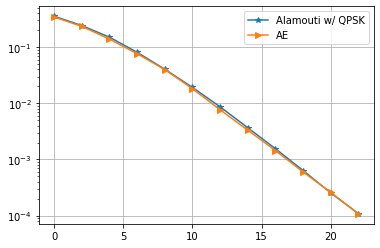

In [8]:
baseline = np.array( [3.552e-1, 2.4243e-01,1.505e-01,8.094e-02,4.04150e-02,\
                    1.9156e-02,8.646e-03,3.6616e-03, 1.5502e-03,\
                    6.33910e-04, 2.53000e-04 ,1.080e-04])
plt.figure()
plt.semilogy(np.arange(0,23,2), baseline,'-*', label='Alamouti w/ QPSK')
plt.semilogy(np.arange(0,23,2), SER, '->', label='AE')
plt.grid(True)
plt.legend()

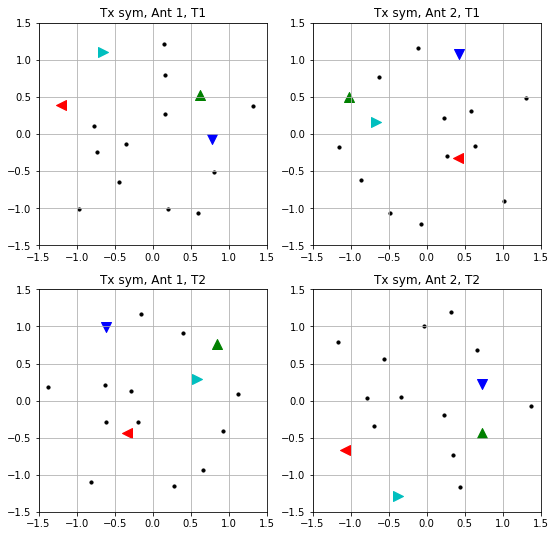

In [9]:
batch = 400
messages = np.arange(M)
messages = np.tile(messages, batch)
test_labels = to_categorical(messages)

csi_real = (torch.randn((M*batch, 2,1))/np.sqrt(2)).to(device)
csi_imag = (torch.randn((M*batch, 2,1))/np.sqrt(2)).to(device)


test_data = torch.from_numpy(test_labels).to(device)
test_label = torch.from_numpy(messages).to(device)

transmitted_signals =encoder(test_data).to('cpu').detach().numpy()


s1 = transmitted_signals[:,0]+ 1j*transmitted_signals[:,4]
s2 = transmitted_signals[:,1]+ 1j*transmitted_signals[:,5]
s3 = transmitted_signals[:,2]+ 1j*transmitted_signals[:,6]
s4 = transmitted_signals[:,3]+ 1j*transmitted_signals[:,7]

a  = 0 #### rotation angles should be carefully find for every different realization
s1 = s1* np.exp(1j*np.pi*a/4)
s2 = s2* np.exp(1j*np.pi*a/4)
s3 = s3* np.exp(1j*np.pi*a/4)
s4 = s4* np.exp(1j*np.pi*a/4)

    


fig, axs = plt.subplots(2, 2, figsize=(9,9))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
for axe in [ax1, ax2, ax3, ax4]:
    axe.grid(True)
    axe.set_xlim([-1.5, 1.5])
    axe.set_ylim([-1.5, 1.5])
#     axe.set_xlabel('Real')
#     axe.set_ylabel('Imaginary')


color_map = ['r', 'b', 'g','r','c', 'm','y','k','w','r', 'b', 'g','r','c', 'm','y','k','w']
marker_style = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X','o']


    

ax1.scatter(s1[0:16].real, s1[0:16].imag, c='k', s=10)    
ax3.scatter(s2[0:16].real, s2[0:16].imag, c='k', s=10)
ax2.scatter(s3[0:16].real, s3[0:16].imag, c='k', s=10)
ax4.scatter(s4[0:16].real, s4[0:16].imag, c='k', s=10)
for i in  np.arange(1,5):
    ax1.scatter(s1[i].real, s1[i].imag, c=color_map[i], s=100, marker=marker_style[i])    
    ax3.scatter(s2[i].real, s2[i].imag, c=color_map[i], s=100, marker=marker_style[i])
    ax2.scatter(s3[i].real, s3[i].imag, c=color_map[i], s=100, marker=marker_style[i])
    ax4.scatter(s4[i].real, s4[i].imag, c=color_map[i], s=100, marker=marker_style[i])


ax1.set_title('Tx sym, Ant 1, T1')
ax2.set_title('Tx sym, Ant 2, T1')
ax3.set_title('Tx sym, Ant 1, T2')
ax4.set_title('Tx sym, Ant 2, T2')


import tikzplotlib
tikzplotlib.save("test.tex")